In [156]:
%load_ext autoreload
%autoreload 2
from utilities.variational import *
from utilities.misc import *
from utilities.chemical import *
from utilities.idinserter import IdInserter
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf
import matplotlib.pyplot as plt
from tqdm import tqdm
from utilities.simplifier import Simplifier
from utilities.unitary_killer import UnitaryMurder



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
fcis=[]
#distances = np.arange(0,3.25,0.25)[1:]
distances = [1.5]
for bd in tqdm(distances):
    problem_config ={"problem" : "H2", "geometry": [('H', (0., 0., 0.)), ('H', (0., 0., bd)), ('H', (0., 0., 2*bd)), ('H', (0., 0., 3*bd))], 
                      "multiplicity":1, "charge":0, "basis":"sto-3g"}

    op = ChemicalObservable()
    hamiltonian = ofpyscf.generate_molecular_hamiltonian(geometry=problem_config["geometry"], basis="sto-3g",
                                                         multiplicity=1, charge=0)

    molecule = MolecularData(
        problem_config["geometry"], basis="sto-3g", multiplicity=1)
    molecule = run_pyscf(molecule,run_scf=0,run_mp2=0,run_cisd=0,run_ccsd=0,run_fci=1)
    fcis.append(molecule.fci_energy)

100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


In [11]:
vqe_handler = VQE(n_qubits=8,problem_config=problem_config)

In [12]:
molecule.fci_energy

-1.9961503255188062

In [13]:
molecule.hf_energy

-1.8291374123569653

# why is there a peak in meta-vqe plot ?! see fig 4 relative errors (also i don't get the units there)

In [74]:
molecule.fci_energy

-1.867291372401372

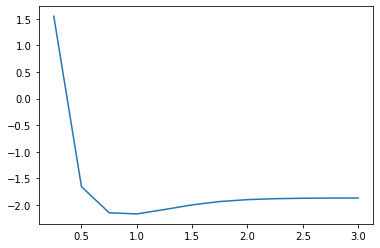

In [73]:
plt.plot(distances,fcis)

In [14]:
indexed_circuit=[vqe_handler.number_of_cnots+k for k in range(vqe_handler.n_qubits,2*vqe_handler.n_qubits)]
energy, symbol_to_value, training_evolution = vqe_handler.vqe(indexed_circuit) #compute energy

In [16]:
vqe_handler.give_circuit(indexed_circuit)

((0, 0): ───Rx(th_0)───

(0, 1): ───Rx(th_1)───

(0, 2): ───Rx(th_2)───

(0, 3): ───Rx(th_3)───

(0, 4): ───Rx(th_4)───

(0, 5): ───Rx(th_5)───

(0, 6): ───Rx(th_6)───

(0, 7): ───Rx(th_7)───,
 ['th_0', 'th_1', 'th_2', 'th_3', 'th_4', 'th_5', 'th_6', 'th_7'],
 {0: 'th_0',
  1: 'th_1',
  2: 'th_2',
  3: 'th_3',
  4: 'th_4',
  5: 'th_5',
  6: 'th_6',
  7: 'th_7'})

In [55]:
vqe_handler = VQE(n_qubits=8,problem_config=problem_config, optimizer="sgd", lr=.001)

idins = IdInserter(n_qubits = len(vqe_handler.qubits))
c=[vqe_handler.number_of_cnots+k for k in range(vqe_handler.n_qubits,2*vqe_handler.n_qubits)]
for i in range(len(vqe_handler.qubits)):
    c+=idins.resolution_2cnots(i,(i+1)%len(vqe_handler.qubits))
c+=[vqe_handler.number_of_cnots+k for k in range(vqe_handler.n_qubits,2*vqe_handler.n_qubits)]

In [56]:
vqe_handler.give_circuit(c)

(                                                                                                                                                                                                                                                                                                                                                                                  ┌──────────┐
(0, 0): ───Rx(th_0)───@───Rz(th_8)────Rx(th_9)────Rz(th_10)───@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X─────────────Rz(th_53)───Rx(th_54)───Rz(th_55)───X───Rx(th_56)───
                      │                                       │                                                                                                                   

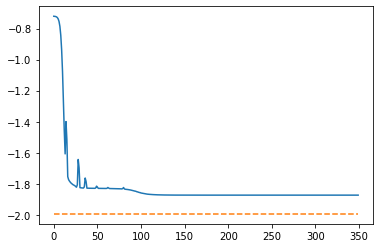

In [58]:

vv = vqe_handler.vqe(c)
plt.plot(vv[-1].history["energy"])
plt.plot(range(len(vv[-1].history["energy"])),np.ones(len(vv[-1].history["energy"]))*vqe_handler.lower_bound_energy,'--')

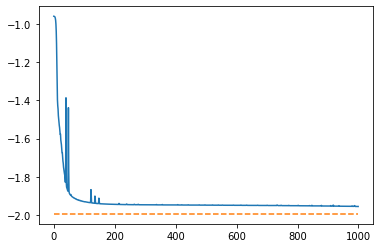

In [61]:
vqe_handler = VQE(n_qubits=8,problem_config=problem_config, optimizer="sgd", lr=.001)

idins = IdInserter(n_qubits = len(vqe_handler.qubits))
c=[vqe_handler.number_of_cnots+k for k in range(vqe_handler.n_qubits,2*vqe_handler.n_qubits)]
for k in range(4):
    for i in range(len(vqe_handler.qubits)):
        c+=idins.resolution_2cnots(i,(i+1)%len(vqe_handler.qubits))
    c+=[vqe_handler.number_of_cnots+k for k in range(vqe_handler.n_qubits,2*vqe_handler.n_qubits)]


vv = vqe_handler.vqe(c)
plt.plot(vv[-1].history["energy"])
plt.plot(range(len(vv[-1].history["energy"])),np.ones(len(vv[-1].history["energy"]))*vqe_handler.lower_bound_energy,'--')

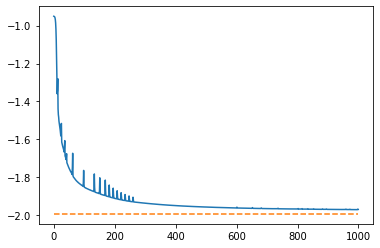

In [62]:
vqe_handler = VQE(n_qubits=8,problem_config=problem_config, optimizer="sgd", lr=.001)

idins = IdInserter(n_qubits = len(vqe_handler.qubits))
c=[vqe_handler.number_of_cnots+k for k in range(vqe_handler.n_qubits,2*vqe_handler.n_qubits)]
for k in range(8):
    for i in range(len(vqe_handler.qubits)):
        c+=idins.resolution_2cnots(i,(i+1)%len(vqe_handler.qubits))
    c+=[vqe_handler.number_of_cnots+k for k in range(vqe_handler.n_qubits,2*vqe_handler.n_qubits)]


vv = vqe_handler.vqe(c)
plt.plot(vv[-1].history["energy"])
plt.plot(range(len(vv[-1].history["energy"])),np.ones(len(vv[-1].history["energy"]))*vqe_handler.lower_bound_energy,'--')

In [67]:
vqe_handler.lower_bound_energy-vv[-1].history["energy"][-1]

-0.024208166247567275

Epoch 1/1000
1/1 [==============================] - 0s 2ms/step - energy: -0.9012 - lr: 0.0200 - grad_norm: 0.6349
Epoch 2/1000
1/1 [==============================] - 0s 912us/step - energy: -0.9138 - lr: 0.0400 - grad_norm: 0.6223
Epoch 3/1000
1/1 [==============================] - 0s 876us/step - energy: -0.9385 - lr: 0.0800 - grad_norm: 0.5961
Epoch 4/1000
1/1 [==============================] - 0s 2ms/step - energy: -0.9850 - lr: 0.1600 - grad_norm: 0.5410
Epoch 5/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.0667 - lr: 0.3200 - grad_norm: 0.4335
Epoch 6/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.1892 - lr: 0.6400 - grad_norm: 0.2848
Epoch 7/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.3410 - lr: 1.2800 - grad_norm: 0.1777
Epoch 8/1000
1/1 [==============================] - 0s 899us/step - energy: -1.5129 - lr: 0.6400 - grad_norm: 0.1586
Epoch 9/1000
1/1 [==============================] - 0s 1ms/step - energy: 

1/1 [==============================] - 0s 893us/step - energy: -1.9547 - lr: 0.3200 - grad_norm: 0.0015
Epoch 72/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9551 - lr: 0.6400 - grad_norm: 0.0015
Epoch 73/1000
1/1 [==============================] - 0s 997us/step - energy: -1.9559 - lr: 0.3200 - grad_norm: 0.0024
Epoch 74/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9560 - lr: 0.1600 - grad_norm: 0.0116
Epoch 75/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9563 - lr: 0.1600 - grad_norm: 0.0129
Epoch 76/1000
1/1 [==============================] - 0s 3ms/step - energy: -1.9574 - lr: 0.3200 - grad_norm: 0.0013
Epoch 77/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9578 - lr: 0.6400 - grad_norm: 0.0013
Epoch 78/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9585 - lr: 0.6400 - grad_norm: 0.0016
Epoch 79/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9590

1/1 [==============================] - 0s 917us/step - energy: -1.9798 - lr: 0.3200 - grad_norm: 9.1873e-04
Epoch 141/1000
1/1 [==============================] - 0s 878us/step - energy: -1.9796 - lr: 0.1600 - grad_norm: 0.0068
Epoch 142/1000
1/1 [==============================] - 0s 905us/step - energy: -1.9795 - lr: 0.0800 - grad_norm: 0.0096
Epoch 143/1000
1/1 [==============================] - 0s 922us/step - energy: -1.9802 - lr: 0.1600 - grad_norm: 4.4942e-04
Epoch 144/1000
1/1 [==============================] - 0s 943us/step - energy: -1.9803 - lr: 0.3200 - grad_norm: 3.5480e-04
Epoch 145/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9804 - lr: 0.6400 - grad_norm: 3.5219e-04
Epoch 146/1000
1/1 [==============================] - 0s 903us/step - energy: -1.9806 - lr: 1.2800 - grad_norm: 3.6155e-04
Epoch 147/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9810 - lr: 0.6400 - grad_norm: 0.0014
Epoch 148/1000
1/1 [===========================

1/1 [==============================] - 0s 8ms/step - energy: -1.9881 - lr: 0.6400 - grad_norm: 1.7567e-04
Epoch 209/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9882 - lr: 0.6400 - grad_norm: 2.1445e-04
Epoch 210/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9883 - lr: 0.3200 - grad_norm: 7.2238e-04
Epoch 211/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9879 - lr: 0.1600 - grad_norm: 0.0069
Epoch 212/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9877 - lr: 0.0800 - grad_norm: 0.0107
Epoch 213/1000
1/1 [==============================] - 0s 3ms/step - energy: -1.9885 - lr: 0.1600 - grad_norm: 3.2915e-04
Epoch 214/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9885 - lr: 0.3200 - grad_norm: 1.6449e-04
Epoch 215/1000
1/1 [==============================] - 0s 969us/step - energy: -1.9886 - lr: 0.6400 - grad_norm: 1.6578e-04
Epoch 216/1000
1/1 [==============================] -

1/1 [==============================] - 0s 1ms/step - energy: -1.9917 - lr: 0.1600 - grad_norm: 8.7484e-04
Epoch 277/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9917 - lr: 0.0800 - grad_norm: 0.0014
Epoch 278/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9918 - lr: 0.1600 - grad_norm: 1.1769e-04
Epoch 279/1000
1/1 [==============================] - 0s 868us/step - energy: -1.9919 - lr: 0.3200 - grad_norm: 9.1774e-05
Epoch 280/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9919 - lr: 0.6400 - grad_norm: 9.2094e-05
Epoch 281/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9919 - lr: 0.6400 - grad_norm: 1.0139e-04
Epoch 282/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9920 - lr: 0.3200 - grad_norm: 2.2874e-04
Epoch 283/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9919 - lr: 0.1600 - grad_norm: 0.0019
Epoch 284/1000
1/1 [==============================] -

1/1 [==============================] - 0s 1ms/step - energy: -1.9937 - lr: 0.6400 - grad_norm: 5.2177e-05
Epoch 345/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9937 - lr: 0.3200 - grad_norm: 7.9453e-05
Epoch 346/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9938 - lr: 0.1600 - grad_norm: 4.4564e-04
Epoch 347/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9937 - lr: 0.0800 - grad_norm: 7.2633e-04
Epoch 348/1000
1/1 [==============================] - 0s 832us/step - energy: -1.9938 - lr: 0.1600 - grad_norm: 6.3585e-05
Epoch 349/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9938 - lr: 0.3200 - grad_norm: 4.7700e-05
Epoch 350/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9938 - lr: 0.6400 - grad_norm: 4.7920e-05
Epoch 351/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9939 - lr: 0.6400 - grad_norm: 5.5426e-05
Epoch 352/1000
1/1 [=========================

1/1 [==============================] - 0s 2ms/step - energy: -1.9943 - lr: 0.0800 - grad_norm: 0.0055
Epoch 412/1000
1/1 [==============================] - 0s 867us/step - energy: -1.9947 - lr: 0.0800 - grad_norm: 0.0010
Epoch 413/1000
1/1 [==============================] - 0s 875us/step - energy: -1.9947 - lr: 0.1600 - grad_norm: 2.3441e-04
Epoch 414/1000
1/1 [==============================] - 0s 883us/step - energy: -1.9947 - lr: 0.3200 - grad_norm: 4.3740e-05
Epoch 415/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9948 - lr: 0.3200 - grad_norm: 3.6152e-05
Epoch 416/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9948 - lr: 0.3200 - grad_norm: 3.9078e-05
Epoch 417/1000
1/1 [==============================] - 0s 940us/step - energy: -1.9948 - lr: 0.1600 - grad_norm: 4.7508e-05
Epoch 418/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9948 - lr: 0.1600 - grad_norm: 6.2735e-05
Epoch 419/1000
1/1 [===========================

1/1 [==============================] - 0s 960us/step - energy: -1.9952 - lr: 0.0200 - grad_norm: 1.6129e-05
Epoch 479/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9952 - lr: 0.0200 - grad_norm: 1.5937e-05
Epoch 480/1000
1/1 [==============================] - 0s 902us/step - energy: -1.9952 - lr: 0.0100 - grad_norm: 1.5855e-05
Epoch 481/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9952 - lr: 0.0100 - grad_norm: 1.5894e-05
Epoch 482/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9952 - lr: 0.0050 - grad_norm: 1.6017e-05
Epoch 483/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9952 - lr: 0.0100 - grad_norm: 1.5862e-05
Epoch 484/1000
1/1 [==============================] - 0s 943us/step - energy: -1.9952 - lr: 0.0200 - grad_norm: 1.6028e-05
Epoch 485/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9952 - lr: 0.0100 - grad_norm: 1.5942e-05
Epoch 486/1000
1/1 [=====================

1/1 [==============================] - 0s 808us/step - energy: -1.9954 - lr: 0.1600 - grad_norm: 4.3811e-04
Epoch 546/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9954 - lr: 0.0800 - grad_norm: 7.6204e-04
Epoch 547/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9955 - lr: 0.0400 - grad_norm: 3.0863e-05
Epoch 548/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9955 - lr: 0.0400 - grad_norm: 1.3539e-05
Epoch 549/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9955 - lr: 0.0200 - grad_norm: 1.1767e-05
Epoch 550/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9955 - lr: 0.0400 - grad_norm: 1.1064e-05
Epoch 551/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9955 - lr: 0.0400 - grad_norm: 1.0485e-05
Epoch 552/1000
1/1 [==============================] - 0s 912us/step - energy: -1.9955 - lr: 0.0800 - grad_norm: 1.0230e-05
Epoch 553/1000
1/1 [=======================

1/1 [==============================] - 0s 1ms/step - energy: -1.9957 - lr: 0.1600 - grad_norm: 1.3798e-05
Epoch 613/1000
1/1 [==============================] - 0s 4ms/step - energy: -1.9957 - lr: 0.0800 - grad_norm: 7.0307e-06
Epoch 614/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9957 - lr: 0.1600 - grad_norm: 6.8085e-06
Epoch 615/1000
1/1 [==============================] - 0s 875us/step - energy: -1.9957 - lr: 0.0800 - grad_norm: 6.7127e-06
Epoch 616/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9957 - lr: 0.1600 - grad_norm: 6.8768e-06
Epoch 617/1000
1/1 [==============================] - 0s 964us/step - energy: -1.9957 - lr: 0.0800 - grad_norm: 6.8085e-06
Epoch 618/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9957 - lr: 0.1600 - grad_norm: 6.6093e-06
Epoch 619/1000
1/1 [==============================] - 0s 890us/step - energy: -1.9957 - lr: 0.3200 - grad_norm: 6.7278e-06
Epoch 620/1000
1/1 [=====================

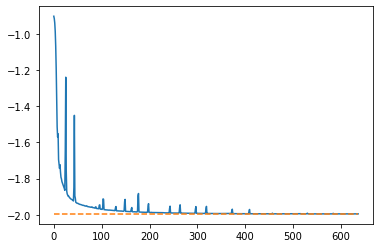

In [70]:
vqe_handler = VQE(n_qubits=8,problem_config=problem_config, optimizer="sgd", lr=.01,verbose=1)

idins = IdInserter(n_qubits = len(vqe_handler.qubits))
c=[vqe_handler.number_of_cnots+k for k in range(vqe_handler.n_qubits,2*vqe_handler.n_qubits)]
for k in range(16):
    for i in range(len(vqe_handler.qubits)):
        c+=idins.resolution_2cnots(i,(i+1)%len(vqe_handler.qubits))
    c+=[vqe_handler.number_of_cnots+k for k in range(vqe_handler.n_qubits,2*vqe_handler.n_qubits)]


vv = vqe_handler.vqe(c)
plt.plot(vv[-1].history["energy"])
plt.plot(range(len(vv[-1].history["energy"])),np.ones(len(vv[-1].history["energy"]))*vqe_handler.lower_bound_energy,'--')

In [72]:
#vqe_handler.give_circuit([vqe_handler.number_of_cnots]) gives Rzalready
cnots=0
for k in c:
    if k < vqe_handler.number_of_cnots:
        cnots+=1

In [74]:
vqe_handler.lower_bound_energy-vv[-1].history["energy"][-1]
#vqe_handler.give_circuit([vqe_handler.number_of_cnots]) gives Rzalready

0.0008961180389321921

In [80]:
#Simplifier reduces gates number as much as possible while keeping same expected value of target hamiltonian
Simp = Simplifier(n_qubits=len(vqe_handler.qubits))
#UnitaryMuerder is in charge of evaluating changes on the energy while setting apart one (or more) parametrized gates. If
killer = UnitaryMurder(vqe_handler, noise_config={})

In [89]:
circuit, symbols, idx_to_symbols = vqe_handler.give_circuit(c)

In [90]:
Sindices, Ssymbols_to_values, Sindex_to_symbols = Simp.reduce_circuit(c, vv[1], idx_to_symbols)

In [92]:
#vqe_handler.give_circuit([vqe_handler.number_of_cnots]) gives Rzalready
cnots=0
for k in Sindices:
    if k < vqe_handler.number_of_cnots:
        cnots+=1

In [93]:
cnots

256

In [98]:
symbol_to_value = vv[1]
index_to_symbols = vqe_handler.give_circuit(c)[-1]
indexed_circuit = c

cnt=0
reduced=True
lmax=len(indexed_circuit)
for k in range(2):
    print("1")
    indexed_circuit, symbol_to_value, index_to_symbols, energy, reduced = killer.unitary_slaughter(indexed_circuit, symbol_to_value, index_to_symbols)
    print(2)
    indexed_circuit, symbol_to_value, index_to_symbols = Simp.reduce_circuit(indexed_circuit, symbol_to_value, index_to_symbols)
    cnt+=1

1


KeyboardInterrupt: 

Epoch 1/1000
1/1 [==============================] - 0s 954us/step - energy: -0.9013 - lr: 0.0200 - grad_norm: 0.3467
Epoch 2/1000
1/1 [==============================] - 0s 854us/step - energy: -0.9083 - lr: 0.0400 - grad_norm: 0.3425
Epoch 3/1000
1/1 [==============================] - 0s 3ms/step - energy: -0.9219 - lr: 0.0800 - grad_norm: 0.3342
Epoch 4/1000
1/1 [==============================] - 0s 906us/step - energy: -0.9483 - lr: 0.1600 - grad_norm: 0.3173
Epoch 5/1000
1/1 [==============================] - 0s 3ms/step - energy: -0.9975 - lr: 0.3200 - grad_norm: 0.2837
Epoch 6/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.0824 - lr: 0.6400 - grad_norm: 0.2228
Epoch 7/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.2052 - lr: 1.2800 - grad_norm: 0.1454
Epoch 8/1000
1/1 [==============================] - 0s 3ms/step - energy: -1.3477 - lr: 1.2800 - grad_norm: 0.0898
Epoch 9/1000
1/1 [==============================] - 0s 1ms/step - energy: 

1/1 [==============================] - 0s 2ms/step - energy: -1.8300 - lr: 0.3200 - grad_norm: 0.0096
Epoch 72/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.8289 - lr: 0.1600 - grad_norm: 0.0418
Epoch 73/1000
1/1 [==============================] - 0s 886us/step - energy: -1.8316 - lr: 0.1600 - grad_norm: 0.0229
Epoch 74/1000
1/1 [==============================] - 0s 876us/step - energy: -1.8339 - lr: 0.3200 - grad_norm: 0.0033
Epoch 75/1000
1/1 [==============================] - 0s 882us/step - energy: -1.8348 - lr: 0.6400 - grad_norm: 0.0030
Epoch 76/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.8366 - lr: 0.3200 - grad_norm: 0.0040
Epoch 77/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.8377 - lr: 0.1600 - grad_norm: 0.0103
Epoch 78/1000
1/1 [==============================] - 0s 3ms/step - energy: -1.8389 - lr: 0.1600 - grad_norm: 0.0068
Epoch 79/1000
1/1 [==============================] - 0s 877us/step - energy: -1.

1/1 [==============================] - 0s 1ms/step - energy: -1.8959 - lr: 0.1600 - grad_norm: 0.0137
Epoch 142/1000
1/1 [==============================] - 0s 904us/step - energy: -1.8972 - lr: 0.3200 - grad_norm: 0.0013
Epoch 143/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.8976 - lr: 0.6400 - grad_norm: 0.0013
Epoch 144/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.8984 - lr: 1.2800 - grad_norm: 0.0014
Epoch 145/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.8995 - lr: 0.6400 - grad_norm: 0.0076
Epoch 146/1000
1/1 [==============================] - 0s 862us/step - energy: -1.8776 - lr: 0.3200 - grad_norm: 0.2862
Epoch 147/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.7286 - lr: 0.1600 - grad_norm: 1.5871
Epoch 148/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.8380 - lr: 0.1600 - grad_norm: 0.6935
Epoch 149/1000
1/1 [==============================] - 0s 918us/step - energ

1/1 [==============================] - 0s 863us/step - energy: -1.9215 - lr: 0.3200 - grad_norm: 0.0906
Epoch 211/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.8790 - lr: 0.1600 - grad_norm: 0.5345
Epoch 212/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9051 - lr: 0.1600 - grad_norm: 0.2667
Epoch 213/1000
1/1 [==============================] - 0s 885us/step - energy: -1.9298 - lr: 0.1600 - grad_norm: 0.0067
Epoch 214/1000
1/1 [==============================] - 0s 841us/step - energy: -1.9304 - lr: 0.3200 - grad_norm: 8.6786e-04
Epoch 215/1000
1/1 [==============================] - 0s 898us/step - energy: -1.9307 - lr: 0.6400 - grad_norm: 7.1177e-04
Epoch 216/1000
1/1 [==============================] - 0s 975us/step - energy: -1.9311 - lr: 0.3200 - grad_norm: 9.5816e-04
Epoch 217/1000
1/1 [==============================] - 0s 3ms/step - energy: -1.9313 - lr: 0.1600 - grad_norm: 0.0027
Epoch 218/1000
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 1ms/step - energy: -1.9462 - lr: 0.1600 - grad_norm: 0.0042
Epoch 279/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9466 - lr: 0.3200 - grad_norm: 4.7592e-04
Epoch 280/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9468 - lr: 0.6400 - grad_norm: 4.0072e-04
Epoch 281/1000
1/1 [==============================] - 0s 999us/step - energy: -1.9470 - lr: 0.3200 - grad_norm: 5.6067e-04
Epoch 282/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9471 - lr: 0.1600 - grad_norm: 0.0017
Epoch 283/1000
1/1 [==============================] - 0s 885us/step - energy: -1.9473 - lr: 0.1600 - grad_norm: 0.0011
Epoch 284/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9474 - lr: 0.3200 - grad_norm: 3.5361e-04
Epoch 285/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9475 - lr: 0.6400 - grad_norm: 3.4709e-04
Epoch 286/1000
1/1 [==============================] - 0

1/1 [==============================] - 0s 843us/step - energy: -1.9563 - lr: 0.6400 - grad_norm: 2.8696e-04
Epoch 347/1000
1/1 [==============================] - 0s 985us/step - energy: -1.9563 - lr: 0.3200 - grad_norm: 6.9421e-04
Epoch 348/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9562 - lr: 0.1600 - grad_norm: 0.0032
Epoch 349/1000
1/1 [==============================] - 0s 846us/step - energy: -1.9564 - lr: 0.1600 - grad_norm: 0.0019
Epoch 350/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9566 - lr: 0.3200 - grad_norm: 2.2794e-04
Epoch 351/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9567 - lr: 0.6400 - grad_norm: 2.1486e-04
Epoch 352/1000
1/1 [==============================] - 0s 3ms/step - energy: -1.9568 - lr: 0.3200 - grad_norm: 2.8618e-04
Epoch 353/1000
1/1 [==============================] - 0s 3ms/step - energy: -1.9569 - lr: 0.1600 - grad_norm: 7.3472e-04
Epoch 354/1000
1/1 [=============================

1/1 [==============================] - 0s 1ms/step - energy: -1.9618 - lr: 0.3200 - grad_norm: 3.9271e-04
Epoch 415/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9618 - lr: 0.1600 - grad_norm: 0.0017
Epoch 416/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9619 - lr: 0.1600 - grad_norm: 9.7043e-04
Epoch 417/1000
1/1 [==============================] - 0s 963us/step - energy: -1.9620 - lr: 0.3200 - grad_norm: 1.5820e-04
Epoch 418/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9620 - lr: 0.6400 - grad_norm: 1.5156e-04
Epoch 419/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9621 - lr: 0.6400 - grad_norm: 1.9096e-04
Epoch 420/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9622 - lr: 0.3200 - grad_norm: 4.3459e-04
Epoch 421/1000
1/1 [==============================] - 0s 3ms/step - energy: -1.9622 - lr: 0.1600 - grad_norm: 0.0019
Epoch 422/1000
1/1 [==============================] -

1/1 [==============================] - 0s 2ms/step - energy: -1.9661 - lr: 0.3200 - grad_norm: 1.2299e-04
Epoch 483/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9661 - lr: 0.6400 - grad_norm: 1.2208e-04
Epoch 484/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9662 - lr: 1.2800 - grad_norm: 1.2932e-04
Epoch 485/1000
1/1 [==============================] - 0s 3ms/step - energy: -1.9663 - lr: 0.6400 - grad_norm: 4.6132e-04
Epoch 486/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9654 - lr: 0.3200 - grad_norm: 0.0122
Epoch 487/1000
1/1 [==============================] - 0s 828us/step - energy: -1.9598 - lr: 0.1600 - grad_norm: 0.0720
Epoch 488/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9631 - lr: 0.1600 - grad_norm: 0.0375
Epoch 489/1000
1/1 [==============================] - 0s 3ms/step - energy: -1.9666 - lr: 0.1600 - grad_norm: 8.0918e-04
Epoch 490/1000
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 2ms/step - energy: -1.9698 - lr: 0.3200 - grad_norm: 1.1429e-04
Epoch 551/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9698 - lr: 0.6400 - grad_norm: 1.0789e-04
Epoch 552/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9699 - lr: 0.3200 - grad_norm: 1.4502e-04
Epoch 553/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9699 - lr: 0.1600 - grad_norm: 3.7548e-04
Epoch 554/1000
1/1 [==============================] - 0s 938us/step - energy: -1.9700 - lr: 0.1600 - grad_norm: 2.4884e-04
Epoch 555/1000
1/1 [==============================] - 0s 890us/step - energy: -1.9700 - lr: 0.3200 - grad_norm: 1.0271e-04
Epoch 556/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9700 - lr: 0.6400 - grad_norm: 1.0108e-04
Epoch 557/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9701 - lr: 1.2800 - grad_norm: 1.0942e-04
Epoch 558/1000
1/1 [=======================

1/1 [==============================] - 0s 1ms/step - energy: -1.9730 - lr: 0.1600 - grad_norm: 2.0600e-04
Epoch 619/1000
1/1 [==============================] - 0s 4ms/step - energy: -1.9730 - lr: 0.3200 - grad_norm: 8.5870e-05
Epoch 620/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9730 - lr: 0.6400 - grad_norm: 8.4935e-05
Epoch 621/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9731 - lr: 1.2800 - grad_norm: 9.0144e-05
Epoch 622/1000
1/1 [==============================] - 0s 855us/step - energy: -1.9732 - lr: 0.6400 - grad_norm: 3.2950e-04
Epoch 623/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9725 - lr: 0.3200 - grad_norm: 0.0088
Epoch 624/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9684 - lr: 0.1600 - grad_norm: 0.0535
Epoch 625/1000
1/1 [==============================] - 0s 892us/step - energy: -1.9707 - lr: 0.1600 - grad_norm: 0.0290
Epoch 626/1000
1/1 [==============================] - 0

1/1 [==============================] - 0s 1ms/step - energy: -1.9756 - lr: 0.6400 - grad_norm: 9.0239e-05
Epoch 687/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9757 - lr: 0.3200 - grad_norm: 2.0317e-04
Epoch 688/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9757 - lr: 0.1600 - grad_norm: 9.0311e-04
Epoch 689/1000
1/1 [==============================] - 0s 890us/step - energy: -1.9757 - lr: 0.1600 - grad_norm: 5.2443e-04
Epoch 690/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9758 - lr: 0.3200 - grad_norm: 7.5618e-05
Epoch 691/1000
1/1 [==============================] - 0s 821us/step - energy: -1.9758 - lr: 0.6400 - grad_norm: 7.1660e-05
Epoch 692/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9758 - lr: 0.6400 - grad_norm: 9.3932e-05
Epoch 693/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9759 - lr: 0.3200 - grad_norm: 2.3116e-04
Epoch 694/1000
1/1 [=======================

1/1 [==============================] - 0s 1ms/step - energy: -1.9776 - lr: 0.6400 - grad_norm: 5.4112e-05
Epoch 754/1000
1/1 [==============================] - 0s 870us/step - energy: -1.9777 - lr: 1.2800 - grad_norm: 5.7691e-05
Epoch 755/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9777 - lr: 0.6400 - grad_norm: 2.1374e-04
Epoch 756/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9773 - lr: 0.3200 - grad_norm: 0.0058
Epoch 757/1000
1/1 [==============================] - 0s 3ms/step - energy: -1.9746 - lr: 0.1600 - grad_norm: 0.0352
Epoch 758/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9761 - lr: 0.1600 - grad_norm: 0.0192
Epoch 759/1000
1/1 [==============================] - 0s 864us/step - energy: -1.9778 - lr: 0.1600 - grad_norm: 3.5454e-04
Epoch 760/1000
1/1 [==============================] - 0s 901us/step - energy: -1.9779 - lr: 0.3200 - grad_norm: 5.7153e-05
Epoch 761/1000
1/1 [==============================] -

1/1 [==============================] - 0s 863us/step - energy: -1.9792 - lr: 0.1600 - grad_norm: 3.2966e-04
Epoch 821/1000
1/1 [==============================] - 0s 920us/step - energy: -1.9792 - lr: 0.3200 - grad_norm: 4.6390e-05
Epoch 822/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9792 - lr: 0.6400 - grad_norm: 4.3817e-05
Epoch 823/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9793 - lr: 0.3200 - grad_norm: 5.6630e-05
Epoch 824/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9793 - lr: 0.1600 - grad_norm: 1.3712e-04
Epoch 825/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9793 - lr: 0.1600 - grad_norm: 9.4072e-05
Epoch 826/1000
1/1 [==============================] - 0s 825us/step - energy: -1.9793 - lr: 0.3200 - grad_norm: 4.1532e-05
Epoch 827/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9793 - lr: 0.6400 - grad_norm: 4.1198e-05
Epoch 828/1000
1/1 [=====================

1/1 [==============================] - 0s 3ms/step - energy: -1.9804 - lr: 0.6400 - grad_norm: 3.6607e-05
Epoch 888/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9804 - lr: 0.3200 - grad_norm: 4.6554e-05
Epoch 889/1000
1/1 [==============================] - 0s 940us/step - energy: -1.9804 - lr: 0.1600 - grad_norm: 1.1154e-04
Epoch 890/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9804 - lr: 0.1600 - grad_norm: 7.7791e-05
Epoch 891/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9804 - lr: 0.3200 - grad_norm: 3.4742e-05
Epoch 892/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9804 - lr: 0.6400 - grad_norm: 3.4468e-05
Epoch 893/1000
1/1 [==============================] - 0s 970us/step - energy: -1.9805 - lr: 1.2800 - grad_norm: 3.6202e-05
Epoch 894/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9805 - lr: 0.6400 - grad_norm: 1.1120e-04
Epoch 895/1000
1/1 [=======================

1/1 [==============================] - 0s 1ms/step - energy: -1.9814 - lr: 0.1600 - grad_norm: 1.0970e-04
Epoch 955/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9814 - lr: 0.1600 - grad_norm: 7.6311e-05
Epoch 956/1000
1/1 [==============================] - 0s 867us/step - energy: -1.9814 - lr: 0.3200 - grad_norm: 3.0297e-05
Epoch 957/1000
1/1 [==============================] - 0s 3ms/step - energy: -1.9814 - lr: 0.6400 - grad_norm: 3.0188e-05
Epoch 958/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.9814 - lr: 1.2800 - grad_norm: 3.2348e-05
Epoch 959/1000
1/1 [==============================] - 0s 960us/step - energy: -1.9815 - lr: 0.6400 - grad_norm: 1.2962e-04
Epoch 960/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9812 - lr: 0.3200 - grad_norm: 0.0037
Epoch 961/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.9794 - lr: 0.1600 - grad_norm: 0.0238
Epoch 962/1000
1/1 [==============================]

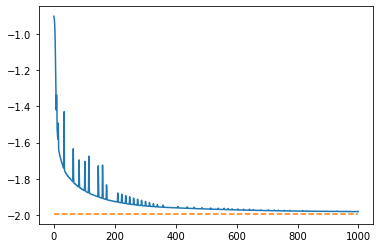

In [102]:
vqe_handler = VQE(n_qubits=8,problem_config=problem_config, optimizer="sgd", lr=.01,verbose=1)

c=[vqe_handler.number_of_cnots+k for k in range(vqe_handler.n_qubits,2*vqe_handler.n_qubits)]
for k in range(10):
    for i in range(len(vqe_handler.qubits)):
        c+=idins.resolution_2cnots(i,(i+1)%len(vqe_handler.qubits))
    c+=[vqe_handler.number_of_cnots+k for k in range(vqe_handler.n_qubits,2*vqe_handler.n_qubits)]


vv = vqe_handler.vqe(c)
plt.plot(vv[-1].history["energy"])
plt.plot(range(len(vv[-1].history["energy"])),np.ones(len(vv[-1].history["energy"]))*vqe_handler.lower_bound_energy,'--')

In [107]:
print(vqe_handler.lower_bound_energy-vv[-1].history["energy"][-1])
#vqe_handler.give_circuit([vqe_handler.number_of_cnots]) gives Rzalready
cnots=0
for k in c:
    if k < vqe_handler.number_of_cnots:
        cnots+=1

-0.013526417857369077


Epoch 1/1000
1/1 [==============================] - 0s 924us/step - energy: -0.9817 - lr: 0.0200 - grad_norm: 0.2239
Epoch 2/1000
1/1 [==============================] - 0s 859us/step - energy: -0.9861 - lr: 0.0400 - grad_norm: 0.2215
Epoch 3/1000
1/1 [==============================] - 0s 1ms/step - energy: -0.9949 - lr: 0.0800 - grad_norm: 0.2167
Epoch 4/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.0121 - lr: 0.1600 - grad_norm: 0.2073
Epoch 5/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.0445 - lr: 0.3200 - grad_norm: 0.1895
Epoch 6/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.1024 - lr: 0.6400 - grad_norm: 0.1583
Epoch 7/1000
1/1 [==============================] - 0s 799us/step - energy: -1.1948 - lr: 1.2800 - grad_norm: 0.1139
Epoch 8/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.3227 - lr: 2.5600 - grad_norm: 0.0856
Epoch 9/1000
1/1 [==============================] - 0s 2ms/step - energy: 

1/1 [==============================] - 0s 1ms/step - energy: -1.7735 - lr: 1.2800 - grad_norm: 5.2950e-05
Epoch 71/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.7735 - lr: 2.5600 - grad_norm: 2.8176e-05
Epoch 72/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.7736 - lr: 5.1200 - grad_norm: 2.5352e-05
Epoch 73/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.7737 - lr: 2.5600 - grad_norm: 3.1329e-05
Epoch 74/1000
1/1 [==============================] - 0s 4ms/step - energy: -1.7737 - lr: 1.2800 - grad_norm: 1.7231e-04
Epoch 75/1000
1/1 [==============================] - 0s 3ms/step - energy: -1.7737 - lr: 0.6400 - grad_norm: 2.7926e-04
Epoch 76/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.7739 - lr: 1.2800 - grad_norm: 1.9372e-05
Epoch 77/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.7739 - lr: 2.5600 - grad_norm: 1.3051e-05
Epoch 78/1000
1/1 [==============================] - 0

1/1 [==============================] - 0s 2ms/step - energy: -1.7744 - lr: 0.6400 - grad_norm: 4.7119e-07
Epoch 138/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.7744 - lr: 1.2800 - grad_norm: 4.6245e-07
Epoch 139/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.7744 - lr: 2.5600 - grad_norm: 4.6534e-07
Epoch 140/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.7744 - lr: 1.2800 - grad_norm: 4.3482e-07
Epoch 141/1000
1/1 [==============================] - 0s 911us/step - energy: -1.7744 - lr: 2.5600 - grad_norm: 4.2842e-07
Epoch 142/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.7744 - lr: 5.1200 - grad_norm: 4.4135e-07
Epoch 143/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.7744 - lr: 10.2400 - grad_norm: 4.1595e-07
Epoch 144/1000
1/1 [==============================] - 0s 828us/step - energy: -1.7744 - lr: 5.1200 - grad_norm: 1.9393e-06
Epoch 145/1000
1/1 [======================

1/1 [==============================] - 0s 2ms/step - energy: -1.7744 - lr: 0.0025 - grad_norm: 2.4862e-07
Epoch 205/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.7744 - lr: 0.0050 - grad_norm: 2.2168e-07
Epoch 206/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.7744 - lr: 0.0025 - grad_norm: 2.3415e-07
Epoch 207/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.7744 - lr: 0.0012 - grad_norm: 2.4399e-07
Epoch 208/1000
1/1 [==============================] - 0s 3ms/step - energy: -1.7744 - lr: 6.2500e-04 - grad_norm: 2.3428e-07
Epoch 209/1000
1/1 [==============================] - 0s 855us/step - energy: -1.7744 - lr: 3.1250e-04 - grad_norm: 2.3557e-07
Epoch 210/1000
1/1 [==============================] - 0s 926us/step - energy: -1.7744 - lr: 1.5625e-04 - grad_norm: 2.3416e-07
Epoch 211/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.7744 - lr: 7.8125e-05 - grad_norm: 2.3577e-07
Epoch 212/1000
1/1 [=======

1/1 [==============================] - 0s 1ms/step - energy: -1.7744 - lr: 2.7105e-22 - grad_norm: 2.3694e-07
Epoch 270/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.7744 - lr: 1.3553e-22 - grad_norm: 2.3694e-07
Epoch 271/1000
1/1 [==============================] - 0s 3ms/step - energy: -1.7744 - lr: 6.7763e-23 - grad_norm: 2.3694e-07
Epoch 272/1000
1/1 [==============================] - 0s 2ms/step - energy: -1.7744 - lr: 3.3881e-23 - grad_norm: 2.3694e-07
Epoch 273/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.7744 - lr: 1.6941e-23 - grad_norm: 2.3694e-07
Epoch 274/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.7744 - lr: 8.4703e-24 - grad_norm: 2.3694e-07
Epoch 275/1000
1/1 [==============================] - 0s 964us/step - energy: -1.7744 - lr: 4.2352e-24 - grad_norm: 2.3694e-07
Epoch 276/1000
1/1 [==============================] - 0s 1ms/step - energy: -1.7744 - lr: 2.1176e-24 - grad_norm: 2.3694e-07
Epoch 277/100

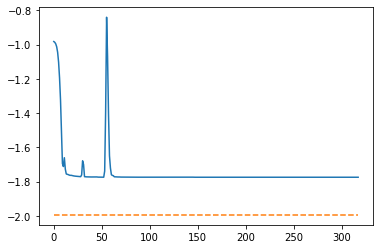

In [109]:
vqe_handler = VQE(n_qubits=8,problem_config=problem_config, optimizer="sgd", lr=.01,verbose=1)

c=[vqe_handler.number_of_cnots+k for k in range(vqe_handler.n_qubits,2*vqe_handler.n_qubits)]
for k in range(1):
    for i in range(len(vqe_handler.qubits)):
        c+=idins.resolution_2cnots(i,(i+1)%len(vqe_handler.qubits))
    c+=[vqe_handler.number_of_cnots+k for k in range(vqe_handler.n_qubits,2*vqe_handler.n_qubits)]

vv = vqe_handler.vqe(c)
plt.plot(vv[-1].history["energy"])
plt.plot(range(len(vv[-1].history["energy"])),np.ones(len(vv[-1].history["energy"]))*vqe_handler.lower_bound_energy,'--')

In [111]:
symbol_to_value = vv[1]
index_to_symbols = vqe_handler.give_circuit(c)[-1]
indexed_circuit = c

cnt=0
reduced=True
lmax=len(indexed_circuit)
for k in range(2):
    print("1")
    indexed_circuit, symbol_to_value, index_to_symbols, energy, reduced = killer.unitary_slaughter(indexed_circuit, symbol_to_value, index_to_symbols)
    print(2)
    indexed_circuit, symbol_to_value, index_to_symbols = Simp.reduce_circuit(indexed_circuit, symbol_to_value, index_to_symbols)
    cnt+=1

1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
2
1
0
1
2
3
4
5
6
7
8
2


In [113]:
len(indexed_circuit)

42

In [114]:
len(c)

80

In [118]:
print(vqe_handler.lower_bound_energy-vv[-1].history["energy"][-1])
#vqe_handler.give_circuit([vqe_handler.number_of_cnots]) gives Rzalready
cnots=0
for k in c:
    if k < vqe_handler.number_of_cnots:
        cnots+=1
print(cnots)

-0.22010896409149994
16


In [ ]:
for k in range(1):
    for i in range(len(vqe_handler.qubits)):
        c+=idins.resolution_2cnots(i,(i+1)%len(vqe_handler.qubits))
    c+=[vqe_handler.number_of_cnots+k for k in range(vqe_handler.n_qubits,2*vqe_handler.n_qubits)]
    
symbol_to_value = vv[1]
index_to_symbols = vqe_handler.give_circuit(indexed_circuit)[-1]
indexed_circuit = c

cnt=0
reduced=True
lmax=len(indexed_circuit)
for k in range(2):
    print("1")
    indexed_circuit, symbol_to_value, index_to_symbols, energy, reduced = killer.unitary_slaughter(indexed_circuit, symbol_to_value, index_to_symbols)
    print(2)
    indexed_circuit, symbol_to_value, index_to_symbols = Simp.reduce_circuit(indexed_circuit, symbol_to_value, index_to_symbols)
    cnt+=1

((0, 0): ───Rx(th_0)────Rz(th_1)────@───────────────────────────
                                   │
(0, 1): ───Rx(th_2)────Rz(th_3)────X───@───────────────────────
                                       │
(0, 2): ───Rx(th_4)────Rz(th_5)────────X───@───────────────────
                                           │
(0, 3): ───Rx(th_6)────Rz(th_7)────────────X───@───────────────
                                               │
(0, 4): ───Rx(th_8)────Rz(th_9)────────────────X───@───────────
                                                   │
(0, 5): ───Rx(th_10)───Rz(th_11)───────────────────X───@───────
                                                       │
(0, 6): ───Rx(th_12)───Rz(th_13)───────────────────────X───@───
                                                           │
(0, 7): ───Rx(th_14)───Rz(th_15)───────────────────────────X───,
 ['th_0',
  'th_1',
  'th_2',
  'th_3',
  'th_4',
  'th_5',
  'th_6',
  'th_7',
  'th_8',
  'th_9',
  'th_10',
  'th_11',
  'th_12',
  'th_13',

In [119]:
vqe_handler.indexed_cnots

{'0': [0, 1],
 '1': [0, 2],
 '2': [0, 3],
 '3': [0, 4],
 '4': [0, 5],
 '5': [0, 6],
 '6': [0, 7],
 '7': [1, 0],
 '8': [1, 2],
 '9': [1, 3],
 '10': [1, 4],
 '11': [1, 5],
 '12': [1, 6],
 '13': [1, 7],
 '14': [2, 0],
 '15': [2, 1],
 '16': [2, 3],
 '17': [2, 4],
 '18': [2, 5],
 '19': [2, 6],
 '20': [2, 7],
 '21': [3, 0],
 '22': [3, 1],
 '23': [3, 2],
 '24': [3, 4],
 '25': [3, 5],
 '26': [3, 6],
 '27': [3, 7],
 '28': [4, 0],
 '29': [4, 1],
 '30': [4, 2],
 '31': [4, 3],
 '32': [4, 5],
 '33': [4, 6],
 '34': [4, 7],
 '35': [5, 0],
 '36': [5, 1],
 '37': [5, 2],
 '38': [5, 3],
 '39': [5, 4],
 '40': [5, 6],
 '41': [5, 7],
 '42': [6, 0],
 '43': [6, 1],
 '44': [6, 2],
 '45': [6, 3],
 '46': [6, 4],
 '47': [6, 5],
 '48': [6, 7],
 '49': [7, 0],
 '50': [7, 1],
 '51': [7, 2],
 '52': [7, 3],
 '53': [7, 4],
 '54': [7, 5],
 '55': [7, 6]}